In [167]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower')
plt.rc('figure', figsize=(10, 6))
font = {'family' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

In [2]:
import pandas as pd
import numpy as np
import astropy.units as u

In [264]:
def file2df(file):
    with open(file, 'r') as ff:
        line = ff.readline()
        cols = line.strip('#').split()
    return pd.read_csv(file, comment='#', delim_whitespace=True, names=cols)


obs = file2df('../LSSTsimWDobs60.dat')
truth = file2df('../LSSTsimWDtruth60.dat')

obs.reset_index(inplace=True)
obs.columns = ['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs', 'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObs', 'muDecObs', 'muErr']

In [4]:
obs.head()

,ra,dec,uObs,uErr,gObs,gErr,rObs,rErr,iObs,iErr,zObs,zErr,yObs,yErr,piObs,piErr,muRAObs,muDecObs,muErr
0,183.487,-1.36738,22.462,0.009,22.274,0.005,22.572,0.005,22.842,0.007,23.127,0.013,23.408,0.048,1.02,0.91,-1.60,-6.76,0.32
1,183.261,-1.25781,25.574,0.106,25.173,0.024,25.251,0.022,25.338,0.046,25.570,0.112,25.723,0.400,1.17,8.95,-3.19,-9.73,3.09
2,183.038,-1.32316,24.688,0.050,24.341,0.012,24.302,0.010,24.356,0.019,24.442,0.042,24.845,0.140,2.90,3.84,1.84,0.17,1.32
3,183.127,-1.13602,23.267,0.015,22.912,0.006,22.835,0.006,22.867,0.007,22.966,0.012,23.066,0.035,0.24,1.11,-12.58,3.17,0.38
4,183.339,-1.39733,23.504,0.018,23.093,0.006,22.963,0.006,22.957,0.007,23.034,0.012,23.088,0.036,-0.23,1.22,-8.69,-10.08,0.42


In [5]:
truth.head()

,ra,dec,u,g,r,i,z,y,Mr,logg,vR,vPhi,vZ,T,P
0,183.487,-1.36738,22.454,22.269,22.566,22.846,23.133,23.420,11.338,8.0,-50.89,-134.57,40.51,1,1
1,183.261,-1.25781,25.549,25.183,25.235,25.364,25.546,25.729,12.346,8.0,-51.56,-53.51,-3.59,1,1
2,183.038,-1.32316,24.718,24.354,24.301,24.356,24.471,24.587,12.867,8.0,-47.11,-170.19,94.17,1,1
3,183.127,-1.13602,23.288,22.913,22.834,22.871,22.972,23.073,12.989,8.0,29.71,-196.22,33.81,1,1
4,183.339,-1.39733,23.517,23.099,22.959,22.960,23.030,23.100,13.249,8.0,-4.74,-187.17,-37.27,1,1


## Problem A

Define a gold parallax sample" by requiring a signal-to-noise ratio of at least 10 for the trigonometric parallax measurement (i.e., piObs/piErr > 10). 

Compute the distance and distance modulus from the parallax measurement (D/kpc=1 milliarcsec/piObs) and compare it to the distance modulus determined from r and Mr listed in the \truth" file. 

In [265]:
# Calculate SNR and define a new dataframe with only gold sample WDs
obs['SNR'] = obs['piObs'] / obs['piErr']
gold_mask = np.abs(obs['SNR']) > 10
obs_gold = obs[gold_mask]

# Calculate the DM of these WDs
obs_gold['D(kpc)'] = 1 / obs_gold['piObs']
obs_gold['DM'] = 5 * np.log10(obs_gold['D(kpc)'] * 1000) - 5

# Calculate the truth DM values
truth['DM'] = truth['r'] - truth['Mr']

# Select the rows corresponding to the gold sample
truth_gold = truth[gold_mask]

<ipython-input-265-db5136659f55>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_gold['D(kpc)'] = 1 / obs_gold['piObs']
<ipython-input-265-db5136659f55>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_gold['DM'] = 5 * np.log10(obs_gold['D(kpc)'] * 1000) - 5


In [7]:
sum(gold_mask)

7156

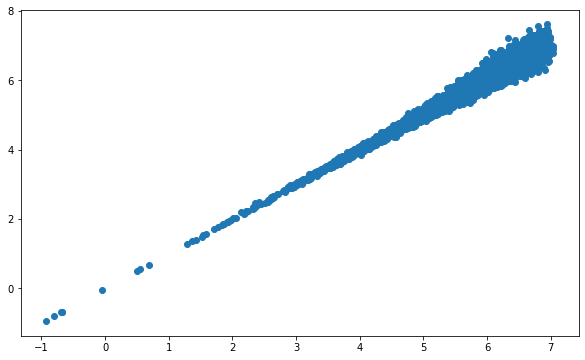

In [8]:
# Plot obs DM vs truth DM for gold sample
plt.scatter(obs_gold['DM'], truth_gold['DM'])


Plot the distribution of the distance modulus difference and compute its median and root-mean-square scatter (hint: beware of outliers and clip at 3sig!). 
- Are they interestingly" small? Is the distribution deviating from a gaussian? 
- Would you expect it to? Why?

In [9]:
diffs_gold = obs_gold['DM'] - truth_gold['DM']

In [10]:
mean =diffs_gold.mean()

In [11]:
med = diffs_gold.median()
med

-0.023409482528964354

In [12]:
rms = diffs_gold.std(ddof=0)
rms

0.1577687249231165

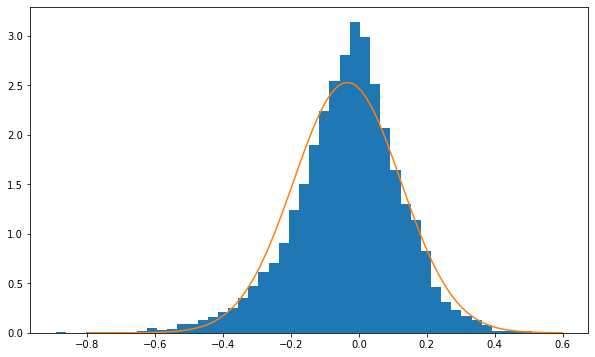

In [13]:
from scipy.stats import norm
plt.hist(diffs_gold, bins=50, density=True)
plt.plot(np.linspace(-.8, .6, 100), norm(mean, rms).pdf(np.linspace(-.8, .6, 100)))

How many white dwarfs would you expect in a \gold parallax sample" from the full LSST survey area of 20,000 deg2 (hint: simply scale by the area because the distance cutoff is smaller than the thin disk scaleheight)? 



Integrating the surface area of a sphere:
\begin{equation}
\int_{0}^{2\pi}\int_{\frac{5\pi}{6}}^{\pi} sin(b) db dl
\end{equation}
We get $2\pi(1-\frac{\sqrt{3}}{2}) \approx 0.8418 Sr$, or roughly $2763 deg^2$

In [36]:
def run_mc(obs, n=100000, dec_bounds=None):
    if dec_bounds is None:
        bounds = {round(ra,1): obs.loc[(obs['ra'] < round(ra, 1) + .1) & (obs['ra'] > round(ra, 1)-.1), 'dec'].quantile([0,1]) for ra in np.linspace(158, 228, 701)}
        dec_bounds = pd.DataFrame(bounds).T.dropna()
        dec_bounds.columns = ['dec_min', 'dec_max']

    ra_min, ra_max = obs['ra'].quantile([0,1])
    dec_min, dec_max = obs['dec'].quantile([0,1])
    
    ras = np.random.choice(np.linspace(0, 359, 360), n)
    decs_weights = np.cos(np.linspace(-np.pi/2, np.pi/2, 91))/sum(np.cos(np.linspace(-np.pi/2, np.pi/2, 91)))
    decs = np.random.choice(np.linspace(-90, 90, 91),n,  p=decs_weights)
    
    mask = (ras > ra_min) & (ras < ra_max) & (decs > dec_min) & (decs < dec_max)
    num = 0
    for ra, dec in zip(ras[mask], decs[mask]):
        # sub = obs.loc[(obs['ra'] < ra + 1) & (obs['ra'] > ra-1)]
        dec_min, dec_max = dec_bounds.loc[round(ra,1)]
        if (dec < dec_max) and (dec > dec_min):
            num+=1
    return num / n



# coords.append((decs, ras))

In [42]:
run_mc(obs, n=10000000, dec_bounds=bounds_df) * 41252

2775.1952984000004

In [44]:
20000/2763 * len(obs_gold)

51798.769453492576

We expect to see roughly 51800 white dwarfs in the full LSST sample meeting our gold standard of SNR > 10.

Plot the (g-r) vs. (u-g) color-color diagram (using observed photometry) for this sample. Does it look crisper than the SDSS distribution 1https://ls.st/lop
2 shown in the bottom left corner of fig. 23 in Ivezic et al. (2007, AJ, 134, 973)?

Text(0.5, 1.0, 'Gold sample $g-r$ vs. $u-g$')

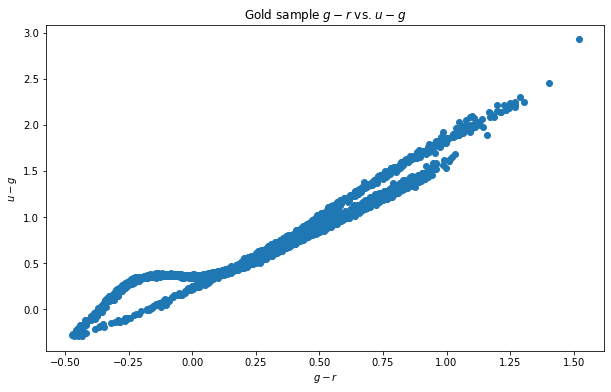

In [50]:
plt.scatter(obs_gold['gObs'] - obs_gold['rObs'], obs_gold['uObs'] - obs_gold['gObs'])
plt.xlabel(r'$g-r$')
plt.ylabel(r'$u-g$')
plt.title(r'Gold sample $g-r$ vs. $u-g$')

# Question B
Using the “gold parallax sample” from A, estimate the absolute r band magnitude as Mobs = rObs − DMobs, with the observed distance modulus, DMobs, determined using the “measured” trigonometric parallax, piObs. Plot Mobs vs. (gObs−rObs) color for stars with T=1 (i.e., hydrogen white WDs; while this is a shortcut based on model input, it is possible to photometrically distinguish hydrogen from helium WDs by considering their four-dimensional color loci; however, this is beyond the scope of this project and hence this shortcut). 

In [266]:
obs_gold['MrObs'] = obs_gold['rObs'] - obs_gold['DM']
hydrogen_WDs = obs_gold.loc[truth_gold['T'] == 1]

<ipython-input-266-ed6645b17f02>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_gold['MrObs'] = obs_gold['rObs'] - obs_gold['DM']


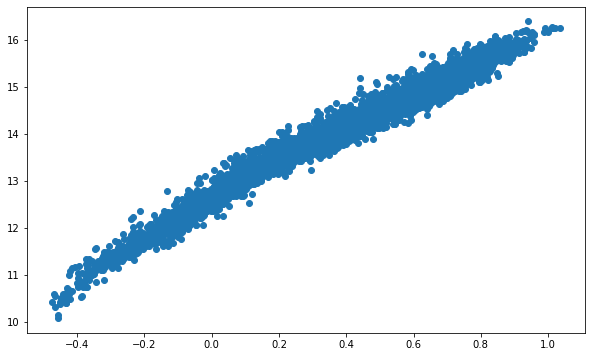

In [64]:
plt.scatter(hydrogen_WDs['gObs'] - hydrogen_WDs['rObs'], hydrogen_WDs['MrObs'])

In [258]:
hydrogen_WDs['MrObs']

47        13.680232
298       13.896473
417       11.717306
515       14.350977
555       14.931453
            ...    
864132    14.516753
877878    15.737504
877996    15.036053
888678    13.464055
903186    14.879170
Name: MrObs, Length: 6394, dtype: float64

Fit a low-order polynomial to derive a photometric parallax relation, Mr(g−r) (hint: you may want to first compute the median Mr in about 0.1 mag wide bins of the g − r color, and then fit a polynomial to these median values vs. g −r bin value). How did you choose the order of your polynomial fit? In what range of Mr and (g − r) is your relation valid?

In [270]:
hydrogen_WDs['g-r'] = hydrogen_WDs['gObs'] - hydrogen_WDs['rObs']


<ipython-input-270-c5e024769356>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hydrogen_WDs['g-r'] = hydrogen_WDs['gObs'] - hydrogen_WDs['rObs']


In [271]:
hydrogen_WDs['g-r'].describe()

count    6394.000000
mean        0.390217
std         0.304312
min        -0.474000
25%         0.155000
50%         0.440000
75%         0.643000
max         1.034000
Name: g-r, dtype: float64

In [282]:
bins = np.arange(-.5, 1.1, .1)
bins = np.arange(hydrogen_WDs['g-r'].min(), hydrogen_WDs['g-r'].max(), .1)
bins = np.array([-0.474, -0.37346667, -0.27293333, -0.1724, -0.07186667, 0.02866667, 0.1292, 0.22973333, 0.33026667, 0.4308, 0.53133333, 0.63186667, 0.7324, 0.83293333, 0.93346667, 1.034])
centers = (bins[1:] + bins[:-1]) / 2

hydrogen_WDs['bin'] = pd.cut(hydrogen_WDs['g-r'], bins, labels=centers).astype(float)
bin_meds = hydrogen_WDs.groupby('bin')['MrObs'].apply(np.median)

<ipython-input-282-5fcdf3762c31>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hydrogen_WDs['bin'] = pd.cut(hydrogen_WDs['g-r'], bins, labels=centers).astype(float)


In [283]:
bin_meds = hydrogen_WDs.groupby('bin')['MrObs'].apply(np.median)
bin_stds = hydrogen_WDs.groupby('bin')['MrObs'].apply(np.std)
bin_counts = hydrogen_WDs.groupby('bin')['MrObs'].agg('count')

In [284]:
bin_sterr = bin_stds / np.sqrt(bin_counts)

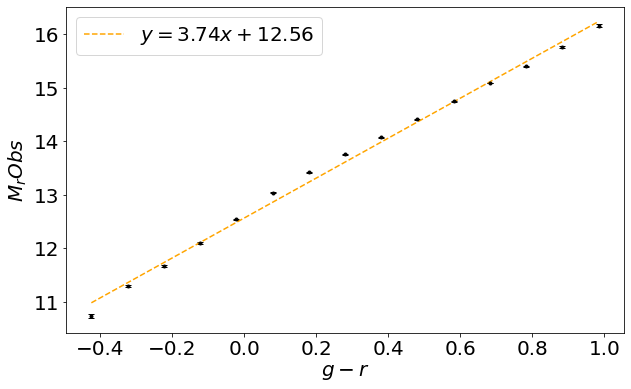

In [285]:
plt.errorbar(bin_meds.index, bin_meds.values, yerr=bin_sterr, fmt='.', color='k', capsize=3, )
plt.plot(bin_meds.index, lin(bin_meds.index, *popt_lin), label=r'$y = {:.2f}x + {:.2f}$'.format(*popt_lin), color='orange', linestyle='--')
#plt.plot(bin_meds.index, quad(bin_meds.index, *popt_quad), label=r'$y = {:.2f}x^2 + {:.2f}x + {:.2f}$'.format(*popt_quad), color='b', linestyle='--')
#plt.plot(bin_meds.index, cubic(bin_meds.index, *popt_cubic), label=r'$y = {:.2f}x^3 + {:.2f}x^2 + {:.2f}x + {:.2f}$'.format(*popt_cubic), color='r', linestyle='--')
plt.legend()
plt.xlabel(r'$g-r$')
plt.ylabel(r'$M_rObs$')
plt.show()

In [286]:
popt_lin

array([ 3.74113587, 12.56224448])

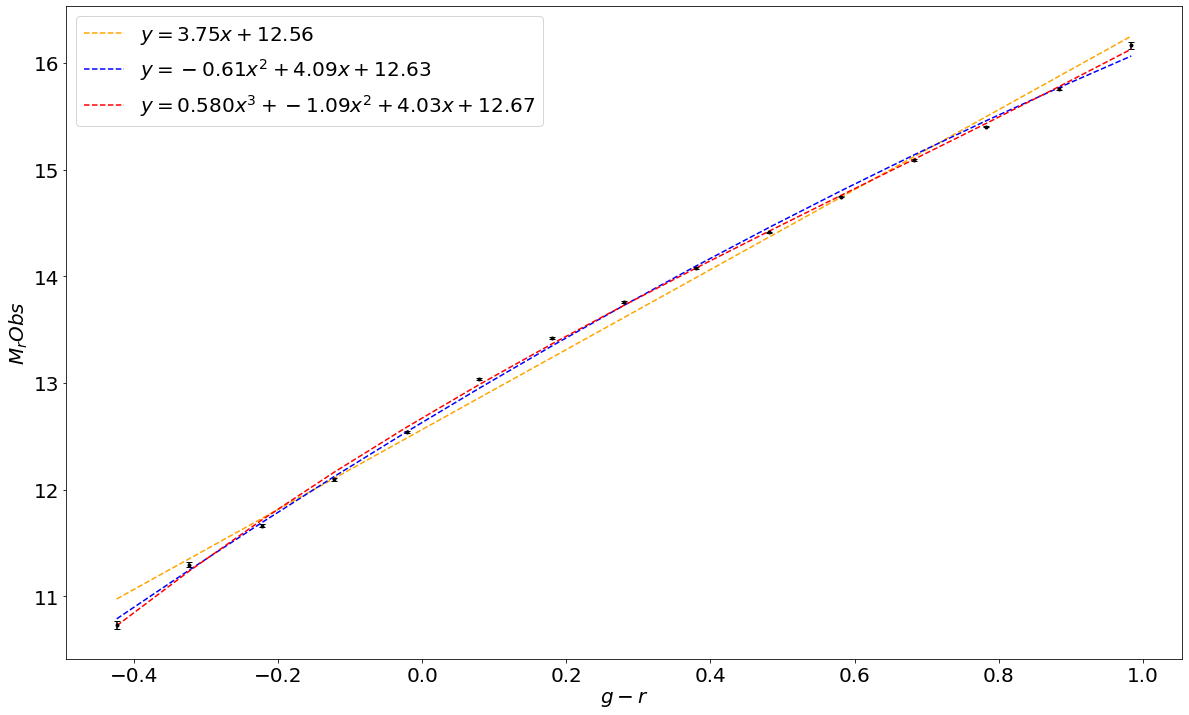

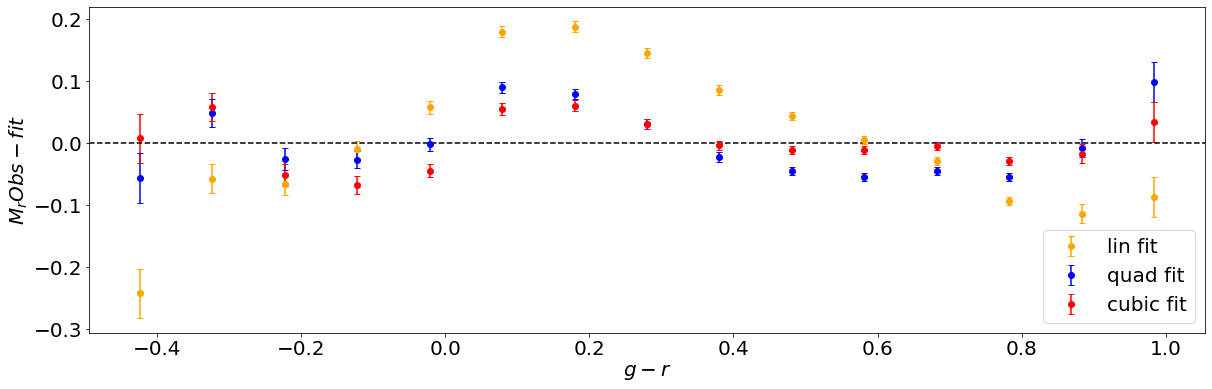

In [288]:
from scipy.optimize import curve_fit
from scipy.stats import chisquare

def lin(x, a, b):
    return a * x + b

def quad(x, a, b, c):
    return a * x ** 2 + b * x + c

def cubic(x, a, b, c, d):
    return a * x ** 3 + b * x ** 2 + c * x  + d

def quar(x, a, b, c, d, e):
    return a * x ** 3 + b * x ** 2 + c * x  + d

def red_chi_sq(obs, exp, err, dof):
    return sum((obs - exp) ** 2 / err ** 2) / (len(obs) - 1- dof)

popt_lin, pcov_lin = curve_fit(lin, bin_meds.index, bin_meds)
popt_quad, pcov_quad = curve_fit(quad, bin_meds.index, bin_meds)
popt_cubic, pcov_cubic = curve_fit(cubic, bin_meds.index, bin_meds)

lin_chi2 = red_chi_sq(bin_meds, lin(bin_meds.index, *popt_lin), bin_sterr, 2)
quad_chi2 = red_chi_sq(bin_meds, quad(bin_meds.index, *popt_quad), bin_sterr, 3)
cubic_chi2 = red_chi_sq(bin_meds, cubic(bin_meds.index, *popt_cubic), bin_sterr, 4)

plt.figure(figsize=(20,12))
plt.errorbar(bin_meds.index, bin_meds.values, yerr=bin_sterr, fmt='.', color='k', capsize=3, )
plt.plot(bin_meds.index, lin(bin_meds.index, *popt_lin), label=r'$y = {:.2f}x + {:.2f}$'.format(*popt_lin), color='orange', linestyle='--')
plt.plot(bin_meds.index, quad(bin_meds.index, *popt_quad), label=r'$y = {:.2f}x^2 + {:.2f}x + {:.2f}$'.format(*popt_quad), color='b', linestyle='--')
plt.plot(bin_meds.index, cubic(bin_meds.index, *popt_cubic), label=r'$y = {:.3f}x^3 + {:.2f}x^2 + {:.2f}x + {:.2f}$'.format(*popt_cubic), color='r', linestyle='--')
plt.legend()
plt.xlabel(r'$g-r$')
plt.ylabel(r'$M_rObs$')
plt.show()

def resid(exp, obs=bin_meds.values):
    return obs - exp

plt.figure(figsize=(20,6))
# plt.errorbar(bin_meds.index, bin_meds.values, yerr=bin_sterr.values, fmt='.', color='k', capsize=3, )
plt.errorbar(bin_meds.index, resid(lin(bin_meds.index, *popt_lin)), yerr=bin_sterr, label='lin fit', color='orange', capsize=3, fmt='o')
plt.errorbar(bin_meds.index, resid(quad(bin_meds.index, *popt_quad)), yerr=bin_sterr, label='quad fit', color='b', capsize=3, fmt='o')
plt.errorbar(bin_meds.index, resid(cubic(bin_meds.index, *popt_cubic)), yerr=bin_sterr, label='cubic fit', color='r', capsize=3, fmt='o')
plt.axhline(0, color='k', ls='--')
plt.legend()
plt.xlabel(r'$g-r$')
plt.ylabel(r'$M_rObs - fit$')
plt.show()

In [238]:
lin_chi2

155.49115051375804

In [239]:
quad_chi2

23.68549052694192

In [240]:
cubic_chi2

11.668520384067678

In [348]:
print(f"Valid from -.4  < g-r < to 1")
print(f"and from {cubic(-.4, *popt_cubic):.2f} < M_r <  {cubic(1, *popt_cubic):.2f}")

Valid from -.4  < g-r < to 1
and from 10.85 < M_r <  16.19


# Question C
Define a “gold proper motion sample” by requiring rObs < 24.5. What fraction of this sample has the observed proper motion measured witha signal-to-noise ratio (to compute SNR: add the two proper motion components in quadrature and divide by the listed proper motion error) of at least 3? 

In [257]:
obs.columns

Index(['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs',
       'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObs',
       ' muDecObs', 'muErr', 'SNR'],
      dtype='object')

In [262]:
ps_gold.columns

Index(['ra', 'dec', 'uObs', 'uErr', 'gObs', 'gErr', 'rObs', 'rErr', 'iObs',
       'iErr', 'zObs', 'zErr', 'yObs', 'yErr', 'piObs', 'piErr', 'muRAObs',
       ' muDecObs', 'muErr', 'SNR'],
      dtype='object')

In [337]:
sum(~ps_mask)

182870

In [360]:
ps_mask = obs['rObs'] < 24.5
ps_gold = obs[ps_mask]
ps_gold['mu'] = np.sqrt(ps_gold['muRAObs'] ** 2 + ps_gold['muDecObs'] ** 2)
print('Proportion of gold proper motion sample with SNR > 3: {:.3f}'.format((ps_gold['mu'] / ps_gold['muErr'] > 3).mean()))

Proportion of gold proper motion sample with SNR > 3: 0.975


<ipython-input-360-9aaf3f96b313>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_gold['mu'] = np.sqrt(ps_gold['muRAObs'] ** 2 + ps_gold['muDecObs'] ** 2)


In [384]:
len(ps_gold)

182757

Apply your photometric parallax relation from B to estimate Mr and distance (using Mr and rObs). Use this distance to compute tangential velocity, vtan (of course, you also need the observed proper motion; be careful about units!). 

In [363]:
ps_gold['g-r'] = ps_gold['gObs'] - ps_gold['rObs']
ps_gold['Phot_Mr'] = cubic(ps_gold['g-r'], *popt_cubic)
ps_gold['D(pc)'] = 10 ** ((ps_gold['rObs'] - ps_gold['Phot_Mr']) / 5 + 1)

<ipython-input-363-2b2f325e62c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_gold['g-r'] = ps_gold['gObs'] - ps_gold['rObs']
<ipython-input-363-2b2f325e62c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_gold['Phot_Mr'] = cubic(ps_gold['g-r'], *popt_cubic)
<ipython-input-363-2b2f325e62c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [453]:
ps_gold['Phot_Mr']

0         11.360011
2         12.828652
3         12.977148
4         13.179670
5         13.303271
            ...    
905971    13.432435
906097    13.084780
906138    12.506103
906143    12.551298
906157    14.647635
Name: Phot_Mr, Length: 182757, dtype: float64

In [383]:
ps_gold['D(pc)']

0         1747.422304
2         1970.923154
3          936.634990
4          905.036350
5         1145.897783
             ...     
905971    1564.274796
906097    1367.237378
906138    2341.959919
906143    2416.241547
906157     781.399096
Name: D(pc), Length: 182757, dtype: float64

<ipython-input-524-eafbb51ac754>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_gold['DM'] = ps_gold['rObs'] - ps_gold['Phot_Mr']


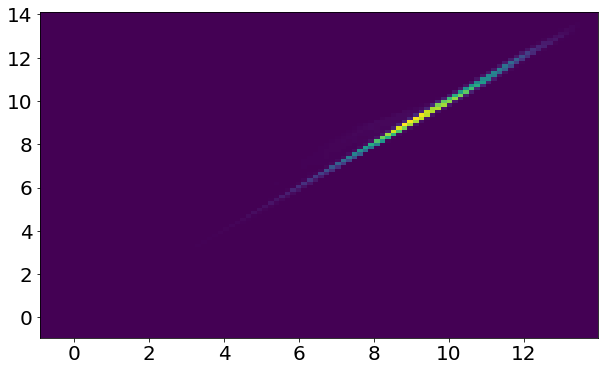

In [524]:
ps_gold['DM'] = ps_gold['rObs'] - ps_gold['Phot_Mr']
plt.hist2d(ps_gold['rObs'] - ps_gold['Phot_Mr'], truth.loc[ps_mask, 'DM'], bins=100)
plt.show()

Define a candidate disk sample as stars with vtan < vcutoff tan , and a candidate halo sample as stars with vtan > vcutoff tan . Using P from the truth file, plot the completeness and contamination for disk and halo samples as a function of v cutoff tan for 0 < vcutoff tan < 500 km/s (in steps of, say, 20 km/s). 

The completeness is defined as the number of (disk, halo) objects in the selected subsample divided by the total number of such objects, and contamination is the number of objects of the “wrong” type in the selected subsample divided by the total number in that subsample.

In [369]:
yr2s = 3.154e7
pc2km = 3.086e13
rad_p_s = (ps_gold['mu'] / 1000 / 3600) * (np.pi / 180) / yr2s
ps_gold['vTan'] =  rad_p_s * ps_gold['D(pc)'] * pc2km

<ipython-input-369-f6d328fb112e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_gold['vTan'] =  rad_p_s * ps_gold['D(pc)'] * pc2km


In [401]:
ps_gold['vTan']

0          57.582410
2          17.275966
3          57.640584
4          57.136284
5          44.523940
             ...    
905971    178.990992
906097    219.534523
906138    164.551978
906143    165.734991
906157    172.235507
Name: vTan, Length: 182757, dtype: float64

In [372]:
def get_comp_cont(sample_index, truth_df, seg):
    n_seg = sum(truth_df['P'] == seg)
    sample_len = len(sample_index)
    
    truth_values = truth_df.loc[sample_index, 'P']
    right = sum(truth_values == seg)
    wrong = sum(truth_values != seg)
    return right / n_seg, wrong / sample_len


disk_results = []
halo_results = []
for v_cutoff in np.linspace(20, 500, 25):
    disk_mask = ps_gold['vTan'] < v_cutoff
    halo_mask = ps_gold['vTan'] > v_cutoff
    
    disk_comp, disk_cont = get_comp_cont(ps_gold.loc[disk_mask].index, truth[ps_mask], 1)
    halo_comp, halo_cont = get_comp_cont(ps_gold.loc[halo_mask].index, truth[ps_mask], 2)
    disk_results.append((v_cutoff, disk_comp, disk_cont))
    halo_results.append((v_cutoff, halo_comp, halo_cont))


In [378]:
disk_df = pd.DataFrame(disk_results, columns=['vTan', 'completeness', 'contamination'])
halo_df = pd.DataFrame(halo_results, columns=['vTan', 'completeness', 'contamination'])
disk_df.set_index('vTan', inplace=True)
halo_df.set_index('vTan', inplace=True)

<AxesSubplot:title={'center':'Halo'}, xlabel='vTan'>

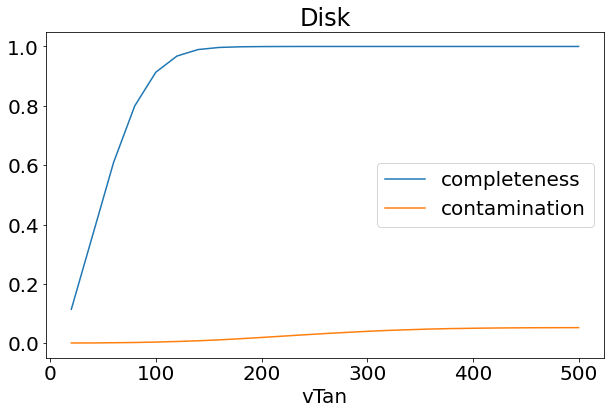

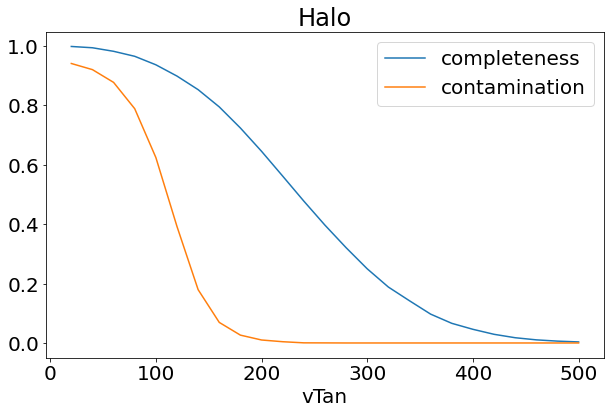

In [382]:
disk_df.plot(title='Disk')
halo_df.plot(title='Halo')

# Question D
Using the “gold proper motion sample” from C, define a candidate disk sample by vtan < 150 km/s, and a candidate halo sample by vtan > 200 km/s. Using your results from C, estimate the completeness and contamination for each subsample. 

In [403]:
v_cutoff = 150 #km/s
disk_mask = ps_gold['vTan'] < v_cutoff
halo_mask = ps_gold['vTan'] > v_cutoff

disk_comp, disk_cont = get_comp_cont(ps_gold.loc[disk_mask].index, truth[ps_mask], 1)
halo_comp, halo_cont = get_comp_cont(ps_gold.loc[halo_mask].index, truth[ps_mask], 2)

print(f'     | completeness | contamination \n' + '-'*35 + \
f'\ndisk |{disk_comp:13.3f} | {disk_cont:13.3f}\n' + '-'*35 + \
f'\nhalo |{halo_comp:13.3f} | {halo_cont:13.3f}')

     | completeness | contamination 
-----------------------------------
disk |        0.994 |         0.010
-----------------------------------
halo |        0.825 |         0.110


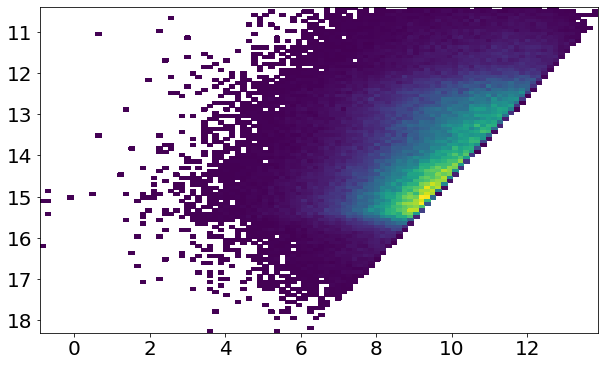

In [530]:
plt.hist2d(ps_gold.loc[disk_mask, 'DM'], ps_gold.loc[disk_mask, 'Phot_Mr'], bins=100, cmin=1)
plt.gca().invert_yaxis()
plt.show()

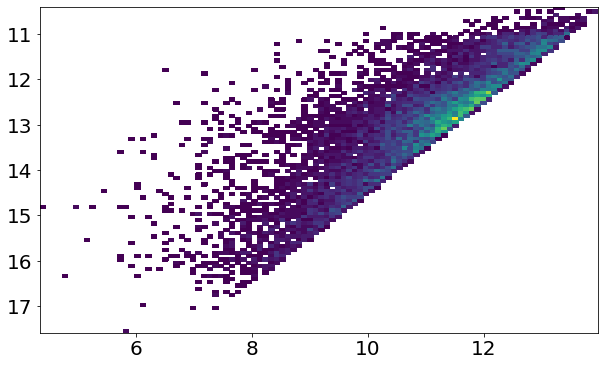

In [532]:
plt.hist2d(ps_gold.loc[halo_mask, 'DM'], ps_gold.loc[halo_mask, 'Phot_Mr'], bins=100, cmin=1)
plt.gca().invert_yaxis()
plt.show()

Using the C method implemented in astroML2, compute the differential luminosity function for each subsample (this is the hardest part of this project!). Explain how did you get the normalization constant. 

In [405]:
from astroML.lumfunc import Cminus

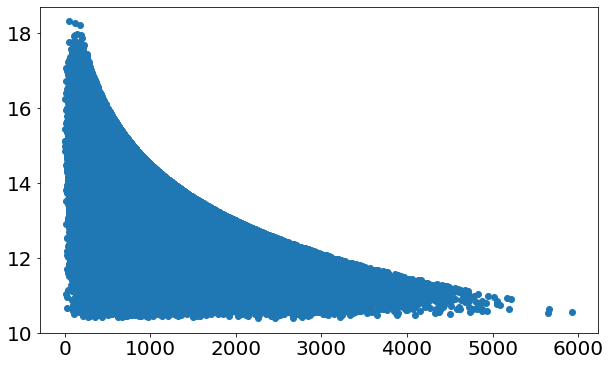

In [408]:
# (x, y) -> (D, Phot_Mr)
plt.scatter(ps_gold.loc[disk_mask, 'D(pc)'], ps_gold.loc[disk_mask, 'Phot_Mr'])

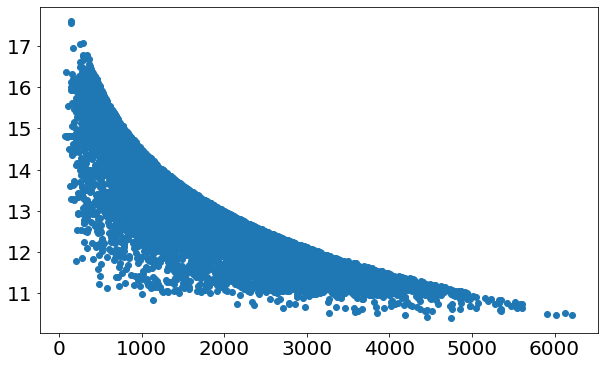

In [409]:
plt.scatter(ps_gold.loc[halo_mask, 'D(pc)'], ps_gold.loc[halo_mask, 'Phot_Mr'])

In [486]:
disk.merge(max_D, left_on='Phot_Mr', right_index=True).columns

Index(['D(pc)_x', 'Phot_Mr', 'D(pc)_y'], dtype='object')

In [488]:
max_D

Phot_Mr
10.40    2670.0
10.42     670.0
10.43    3220.0
10.44    2490.0
10.45    2030.0
          ...  
17.96     120.0
17.98     150.0
18.20     180.0
18.28     120.0
18.31      50.0
Name: D(pc), Length: 730, dtype: float64

In [534]:
disk = ps_gold.loc[disk_mask, ['D(pc)', 'Phot_Mr']].round({'D(pc)':-2, 'Phot_Mr':1})
disk_max_D = disk.groupby('Phot_Mr')['D(pc)'].apply(max)
disk_max_Mr = disk.groupby('D(pc)')['Phot_Mr'].apply(max)

disk_max_D.name = 'max D(pc)'
disk_max_Mr.name = 'max Phot_Mr'

disk_data = disk.merge(max_D, left_on='Phot_Mr', right_index=True).merge(max_Mr, left_on='D(pc)', right_index=True)

disk_x = disk_data['D(pc)']
disk_y = disk_data['Phot_Mr']
disk_xmax = disk_data['max D(pc)']
disk_ymax = disk_data['max Phot_Mr']

disk_Nx, disk_Ny, disk_cuml_x, disk_cuml_y = Cminus(disk_x, disk_y, disk_xmax, disk_ymax)

In [535]:
halo = ps_gold.loc[halo_mask, ['D(pc)', 'Phot_Mr']].round({'D(pc)':-2, 'Phot_Mr':1})
disk_max_D = halo.groupby('Phot_Mr')['D(pc)'].apply(max)
disk_max_Mr = halo.groupby('D(pc)')['Phot_Mr'].apply(max)

disk_max_D.name = 'max D(pc)'
disk_max_Mr.name = 'max Phot_Mr'

halo_data = halo.merge(max_D, left_on='Phot_Mr', right_index=True).merge(max_Mr, left_on='D(pc)', right_index=True)

halo_x = halo_data['D(pc)']
halo_y = halo_data['Phot_Mr']
halo_xmax = halo_data['max D(pc)']
halo_ymax = halo_data['max Phot_Mr']

halo_Nx, halo_Ny, halo_cuml_x, halo_cuml_y = Cminus(halo_x, halo_y, halo_xmax, halo_ymax)

C:\Users\ykwan\Anaconda3\lib\site-packages\astroML\lumfunc.py:76: RuntimeWarning: divide by zero encountered in true_divide
  cuml_y = np.cumprod(1. + 1. / Ny)
C:\Users\ykwan\Anaconda3\lib\site-packages\astroML\lumfunc.py:80: RuntimeWarning: invalid value encountered in multiply
  cuml_y *= Nall / cuml_y[-1]


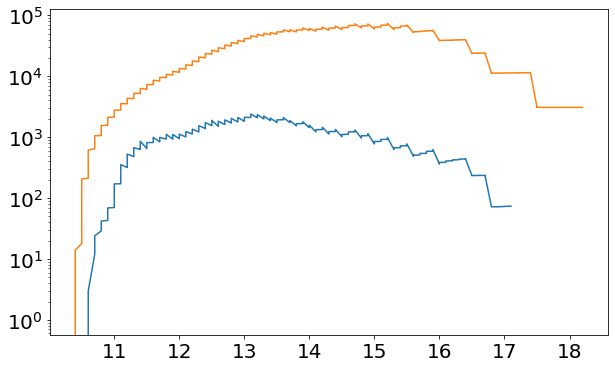

In [536]:
plt.semilogy(halo_y.sort_values(), halo_Ny)
plt.semilogy(disk_y.sort_values(), disk_Ny)

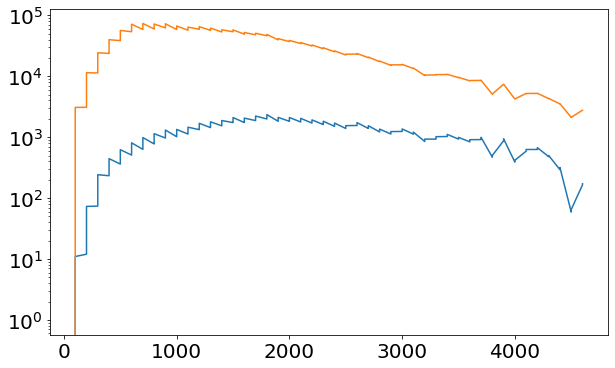

In [537]:
plt.semilogy(halo_x.sort_values(), halo_Nx)
plt.semilogy(disk_x.sort_values(), disk_Nx)

Plot your results in a log(Φ) vs. Mr diagram (with error bars!), and overplot the true luminosity function listed in files WDlumfuncDisk.dat and WDlumfuncHalo.dat (the differential LF listed in the second column is expressed as the number of stars per pc3 and mag; the LFs are slightly inconsistent with the Harris et al. due to a bug in simulations but, importantly, they do correspond to the “true” LFs for the simulated sample). 

Comment on (dis)agreement between your Φ and the true Φ (which was used to generate the simulated sample). IMPORTANT - YOU NEED TO FIX A BUG: Divide the halo Φ from file WDlumfuncHalo.dat by 200 to get a proper normalization in units of stars per pc3 and mag